In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

c:\Users\Subrik\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('diabetes_.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Датасет состоит из 768 записей (строк) и 9 признаков (столбцов):

1. Pregnancies: Количество беременностей.
2. Glucose: Уровень глюкозы в плазме (за 2 часа теста на толерантность к глюкозе).
3. BloodPressure: Диастолическое артериальное давление (мм рт. ст.).
4. SkinThickness: Толщина кожной складки трицепса (мм).
5. Insulin: Уровень инсулина в сыворотке крови (μU/ml).
6. BMI: Индекс массы тела (вес в кг/(рост в м)^2).
7. DiabetesPedigreeFunction: Функция родства диабета (оценка вероятности диабета на основе наследственности).
8. Age: Возраст (лет).
9. Outcome: Целевая переменная (1 – наличие диабета, 0 – отсутствие диабета).

In [4]:
# Масштабирование признаков

scaler = StandardScaler()
df[['Pregnancies', 
    'Glucose', 
    'BloodPressure', 
    'SkinThickness', 
    'Insulin', 
    'BMI', 
    'Age']
] = scaler.fit_transform(df[[
    'Pregnancies', 
    'Glucose', 
    'BloodPressure', 
    'SkinThickness', 
    'Insulin', 
    'BMI', 
    'Age']]
)

# DiabetesPedigreeFunction нет смысла масштабировать, значение признака в любом случае довольно мало и он будет отброшен

In [5]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.627,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,0.351,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.672,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,0.167,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,2.288,-0.020496,1
5,0.342981,-0.153185,0.253036,-1.288212,-0.692891,-0.811341,0.201,-0.275760,0
6,-0.250952,-1.342476,-0.987710,0.719086,0.071204,-0.125977,0.248,-0.616111,1
7,1.827813,-0.184482,-3.572597,-1.288212,-0.692891,0.419775,0.134,-0.360847,0
8,-0.547919,2.381884,0.046245,1.534551,4.021922,-0.189437,0.158,1.681259,1
9,1.233880,0.128489,1.390387,-1.288212,-0.692891,-4.060474,0.232,1.766346,1


In [6]:
X = df.drop(columns = ['Outcome'])
y = df['Outcome']

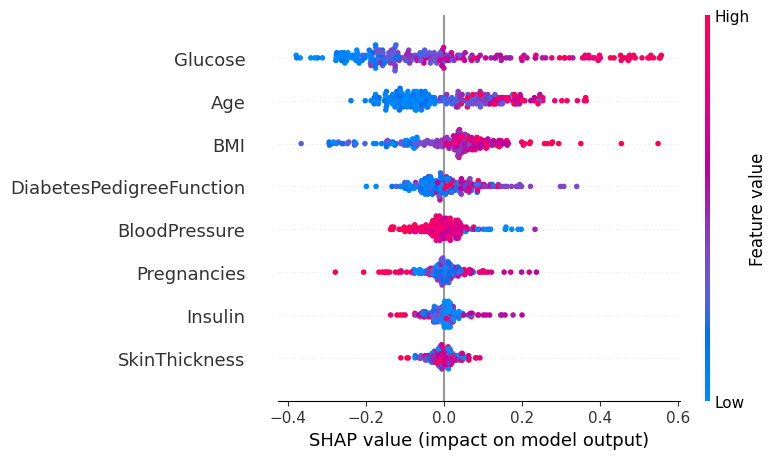

In [7]:
# Используем SHAP и посмотрим, как каждый признак влияет на предсказания модели при таком подходе

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]

# Обучение модели XGBoost
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

# Инициализация Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)

[LightGBM] [Info] Number of positive: 188, number of negative: 349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 613
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350093 -> initscore=-0.618630
[LightGBM] [Info] Start training from score -0.618630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

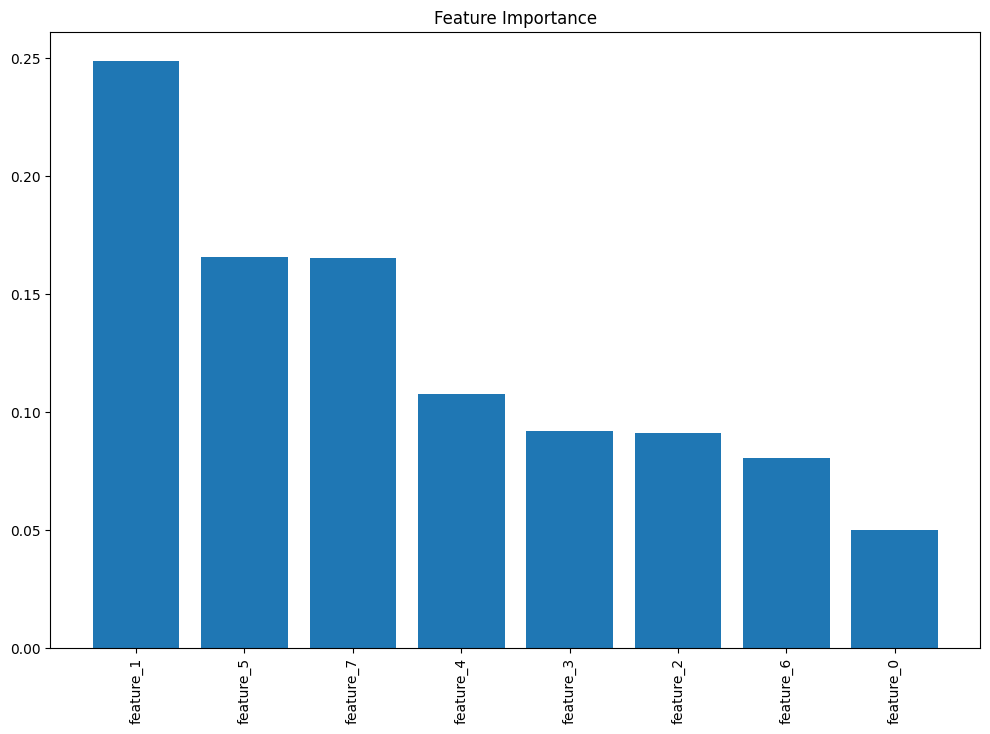

Feature importances: [0.04982475 0.24845707 0.09096321 0.09212296 0.10759836 0.16558759
 0.08042467 0.16502139]


In [8]:
# Обучение модели с использованием градиентного бустинга и оценка значимости признаков

# Модель LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Оценка значимости признаков
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация значимости признаков
plt.figure(figsize = (12, 8))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align = "center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation = 90)
plt.show()

# Вывод значимых признаков
print(f"Feature importances: {importances}")

In [9]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.627,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,0.351,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.672,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,0.167,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,2.288,-0.020496,1
5,0.342981,-0.153185,0.253036,-1.288212,-0.692891,-0.811341,0.201,-0.275760,0
6,-0.250952,-1.342476,-0.987710,0.719086,0.071204,-0.125977,0.248,-0.616111,1
7,1.827813,-0.184482,-3.572597,-1.288212,-0.692891,0.419775,0.134,-0.360847,0
8,-0.547919,2.381884,0.046245,1.534551,4.021922,-0.189437,0.158,1.681259,1
9,1.233880,0.128489,1.390387,-1.288212,-0.692891,-4.060474,0.232,1.766346,1


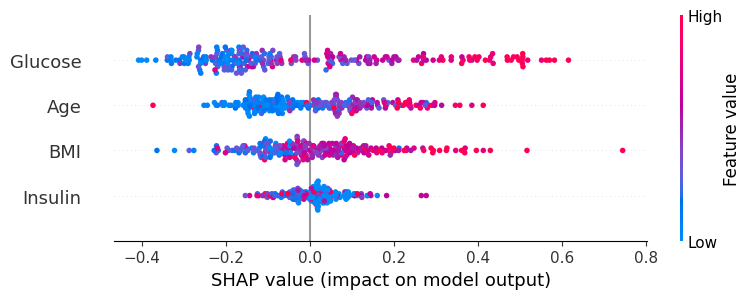

In [11]:
# Повторно обучаем модель с использованием наиболее значимых признаков и визуализируем с помощью графика SHAP

# Отбрасываем признаки с наименьшей значимостью
X_drop = df.drop(columns = ['Pregnancies', 'BloodPressure', 'SkinThickness', 'DiabetesPedigreeFunction', 'Outcome'])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size = 0.3, random_state = 42)
feature_names = [f'feature_{i}' for i in range(X_drop.shape[1])]

# Обучение модели XGBoost
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

# Инициализация Explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)